In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


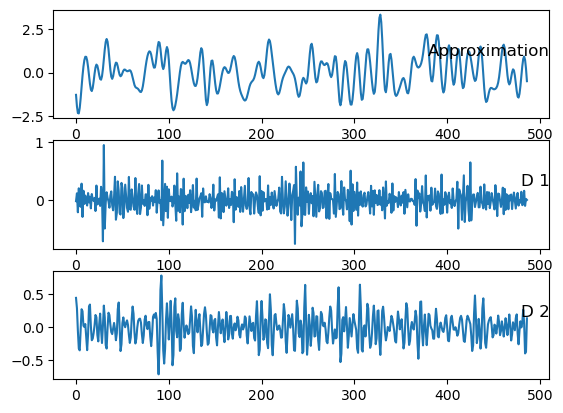

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('wavelet_coefficients_dmey.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,1,2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [3]:
dataset

,Approximation,D 1,D 2
Original Signal,,,
-0.92,-1.289549,-0.019689,0.443432
0.10,-1.953723,0.114628,0.287074
0.22,-2.338011,-0.210739,-0.053620
1.02,-2.363552,0.200536,-0.322405
1.70,-2.049215,-0.072359,-0.350193
...,...,...,...
1.19,0.780130,-0.073466,0.263766
1.69,0.922919,0.157779,0.052857
1.73,0.733728,-0.100658,-0.396809


In [4]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [55]:
# load dataset
dataset = read_csv('wavelet_coefficients_dmey.csv')
dataset=dataset.drop([ 'D 1', 'D 2'], axis=1)


In [56]:
dataset

,Original Signal,Approximation
0,-0.92,-1.289549
1,0.10,-1.953723
2,0.22,-2.338011
3,1.02,-2.363552
4,1.70,-2.049215
...,...,...
482,1.19,0.780130
483,1.69,0.922919
484,1.73,0.733728
485,1.81,0.227402


In [57]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[2,3,6]], axis=1, inplace=True)
# print(reframed.head())

     var1(t-1)  var2(t-1)   var1(t)   var2(t)
1     0.298770   0.080247  0.478032  0.012346
2     0.478032   0.012346  0.499121  0.002058
3     0.499121   0.002058  0.639719  0.000000
4     0.639719   0.000000  0.759227  0.008230
5     0.759227   0.008230  0.743410  0.055556
..         ...        ...       ...       ...
482   0.625659   0.652263  0.669596  0.802469
483   0.669596   0.802469  0.757469  0.837449
484   0.757469   0.837449  0.764499  0.786008
485   0.764499   0.786008  0.778559  0.584362
486   0.778559   0.584362  0.773286  0.318930

[486 rows x 4 columns]


In [58]:
reframed

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.298770,0.080247,0.478032,0.012346
2,0.478032,0.012346,0.499121,0.002058
3,0.499121,0.002058,0.639719,0.000000
4,0.639719,0.000000,0.759227,0.008230
5,0.759227,0.008230,0.743410,0.055556
...,...,...,...,...
482,0.625659,0.652263,0.669596,0.802469
483,0.669596,0.802469,0.757469,0.837449
484,0.757469,0.837449,0.764499,0.786008
485,0.764499,0.786008,0.778559,0.584362


In [59]:

# split into train and test sets
values = reframed.values
n_train_hours = 392
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(392, 1, 3) (392,) (94, 1, 3) (94,)


In [60]:
from tensorflow import keras
from tensorflow.keras import layers

In [61]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adamax')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/1000
13/13 - 2s - loss: 0.5082 - val_loss: 0.4509 - 2s/epoch - 153ms/step
Epoch 2/1000
13/13 - 0s - loss: 0.4319 - val_loss: 0.3805 - 58ms/epoch - 4ms/step
Epoch 3/1000
13/13 - 0s - loss: 0.3745 - val_loss: 0.3212 - 49ms/epoch - 4ms/step
Epoch 4/1000
13/13 - 0s - loss: 0.3290 - val_loss: 0.2796 - 44ms/epoch - 3ms/step
Epoch 5/1000
13/13 - 0s - loss: 0.2921 - val_loss: 0.2540 - 54ms/epoch - 4ms/step
Epoch 6/1000
13/13 - 0s - loss: 0.2639 - val_loss: 0.2381 - 50ms/epoch - 4ms/step
Epoch 7/1000
13/13 - 0s - loss: 0.2434 - val_loss: 0.2292 - 46ms/epoch - 4ms/step
Epoch 8/1000
13/13 - 0s - loss: 0.2289 - val_loss: 0.2234 - 52ms/epoch - 4ms/step
Epoch 9/1000
13/13 - 0s - loss: 0.2194 - val_loss: 0.2214 - 47ms/epoch - 4ms/step
Epoch 10/1000
13/13 - 0s - loss: 0.2129 - val_loss: 0.2207 - 52ms/epoch - 4ms/step
Epoch 11/1000
13/13 - 0s - loss: 0.2083 - val_loss: 0.2198 - 46ms/epoch - 4ms/step
Epoch 12/1000
13/13 - 0s - loss: 0.2049 - val_loss: 0.2183 - 54ms/epoch - 4ms/step
Epoch 13/1000

Epoch 100/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1054 - 50ms/epoch - 4ms/step
Epoch 101/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1054 - 47ms/epoch - 4ms/step
Epoch 102/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 49ms/epoch - 4ms/step
Epoch 103/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 50ms/epoch - 4ms/step
Epoch 104/1000
13/13 - 0s - loss: 0.0849 - val_loss: 0.1053 - 49ms/epoch - 4ms/step
Epoch 105/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 51ms/epoch - 4ms/step
Epoch 106/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 50ms/epoch - 4ms/step
Epoch 107/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1054 - 51ms/epoch - 4ms/step
Epoch 108/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1052 - 53ms/epoch - 4ms/step
Epoch 109/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 47ms/epoch - 4ms/step
Epoch 110/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 45ms/epoch - 3ms/step
Epoch 111/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1053 - 49ms/epoch - 4

Epoch 198/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1047 - 50ms/epoch - 4ms/step
Epoch 199/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1048 - 48ms/epoch - 4ms/step
Epoch 200/1000
13/13 - 0s - loss: 0.0848 - val_loss: 0.1048 - 51ms/epoch - 4ms/step
Epoch 201/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1049 - 51ms/epoch - 4ms/step
Epoch 202/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1047 - 51ms/epoch - 4ms/step
Epoch 203/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1049 - 47ms/epoch - 4ms/step
Epoch 204/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1048 - 50ms/epoch - 4ms/step
Epoch 205/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1049 - 52ms/epoch - 4ms/step
Epoch 206/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1048 - 52ms/epoch - 4ms/step
Epoch 207/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1049 - 51ms/epoch - 4ms/step
Epoch 208/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1048 - 49ms/epoch - 4ms/step
Epoch 209/1000
13/13 - 0s - loss: 0.0847 - val_loss: 0.1048 - 48ms/epoch - 4

Epoch 296/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 51ms/epoch - 4ms/step
Epoch 297/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 52ms/epoch - 4ms/step
Epoch 298/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1045 - 51ms/epoch - 4ms/step
Epoch 299/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 55ms/epoch - 4ms/step
Epoch 300/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 48ms/epoch - 4ms/step
Epoch 301/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 50ms/epoch - 4ms/step
Epoch 302/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1047 - 50ms/epoch - 4ms/step
Epoch 303/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1047 - 52ms/epoch - 4ms/step
Epoch 304/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 59ms/epoch - 5ms/step
Epoch 305/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1045 - 63ms/epoch - 5ms/step
Epoch 306/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 52ms/epoch - 4ms/step
Epoch 307/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1046 - 58ms/epoch - 4

Epoch 394/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1043 - 46ms/epoch - 4ms/step
Epoch 395/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1045 - 48ms/epoch - 4ms/step
Epoch 396/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1044 - 44ms/epoch - 3ms/step
Epoch 397/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1044 - 49ms/epoch - 4ms/step
Epoch 398/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 51ms/epoch - 4ms/step
Epoch 399/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1044 - 57ms/epoch - 4ms/step
Epoch 400/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1042 - 57ms/epoch - 4ms/step
Epoch 401/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1044 - 51ms/epoch - 4ms/step
Epoch 402/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 49ms/epoch - 4ms/step
Epoch 403/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1044 - 47ms/epoch - 4ms/step
Epoch 404/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 51ms/epoch - 4ms/step
Epoch 405/1000
13/13 - 0s - loss: 0.0846 - val_loss: 0.1043 - 49ms/epoch - 4

Epoch 492/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 54ms/epoch - 4ms/step
Epoch 493/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 46ms/epoch - 4ms/step
Epoch 494/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 47ms/epoch - 4ms/step
Epoch 495/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 496/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 46ms/epoch - 4ms/step
Epoch 497/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1044 - 51ms/epoch - 4ms/step
Epoch 498/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 52ms/epoch - 4ms/step
Epoch 499/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1047 - 50ms/epoch - 4ms/step
Epoch 500/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1043 - 49ms/epoch - 4ms/step
Epoch 501/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 50ms/epoch - 4ms/step
Epoch 502/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 503/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 46ms/epoch - 4

Epoch 590/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1045 - 48ms/epoch - 4ms/step
Epoch 591/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 50ms/epoch - 4ms/step
Epoch 592/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 47ms/epoch - 4ms/step
Epoch 593/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 49ms/epoch - 4ms/step
Epoch 594/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 47ms/epoch - 4ms/step
Epoch 595/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 50ms/epoch - 4ms/step
Epoch 596/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 597/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 49ms/epoch - 4ms/step
Epoch 598/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 599/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 49ms/epoch - 4ms/step
Epoch 600/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 601/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 47ms/epoch - 4

Epoch 688/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 50ms/epoch - 4ms/step
Epoch 689/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 49ms/epoch - 4ms/step
Epoch 690/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 54ms/epoch - 4ms/step
Epoch 691/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 49ms/epoch - 4ms/step
Epoch 692/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 51ms/epoch - 4ms/step
Epoch 693/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1043 - 48ms/epoch - 4ms/step
Epoch 694/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 49ms/epoch - 4ms/step
Epoch 695/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 50ms/epoch - 4ms/step
Epoch 696/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1042 - 50ms/epoch - 4ms/step
Epoch 697/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 49ms/epoch - 4ms/step
Epoch 698/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 50ms/epoch - 4ms/step
Epoch 699/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 48ms/epoch - 4

Epoch 786/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1044 - 48ms/epoch - 4ms/step
Epoch 787/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1041 - 49ms/epoch - 4ms/step
Epoch 788/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 49ms/epoch - 4ms/step
Epoch 789/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 49ms/epoch - 4ms/step
Epoch 790/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 50ms/epoch - 4ms/step
Epoch 791/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 51ms/epoch - 4ms/step
Epoch 792/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 50ms/epoch - 4ms/step
Epoch 793/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 49ms/epoch - 4ms/step
Epoch 794/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 51ms/epoch - 4ms/step
Epoch 795/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 49ms/epoch - 4ms/step
Epoch 796/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1041 - 48ms/epoch - 4ms/step
Epoch 797/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 50ms/epoch - 4

Epoch 884/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 55ms/epoch - 4ms/step
Epoch 885/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 52ms/epoch - 4ms/step
Epoch 886/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1040 - 52ms/epoch - 4ms/step
Epoch 887/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 52ms/epoch - 4ms/step
Epoch 888/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1041 - 50ms/epoch - 4ms/step
Epoch 889/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 47ms/epoch - 4ms/step
Epoch 890/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1040 - 48ms/epoch - 4ms/step
Epoch 891/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1043 - 53ms/epoch - 4ms/step
Epoch 892/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1041 - 55ms/epoch - 4ms/step
Epoch 893/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 59ms/epoch - 5ms/step
Epoch 894/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1041 - 57ms/epoch - 4ms/step
Epoch 895/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 48ms/epoch - 4

Epoch 982/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 46ms/epoch - 4ms/step
Epoch 983/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1041 - 46ms/epoch - 4ms/step
Epoch 984/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 46ms/epoch - 4ms/step
Epoch 985/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1040 - 48ms/epoch - 4ms/step
Epoch 986/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1042 - 54ms/epoch - 4ms/step
Epoch 987/1000
13/13 - 0s - loss: 0.0844 - val_loss: 0.1040 - 52ms/epoch - 4ms/step
Epoch 988/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 47ms/epoch - 4ms/step
Epoch 989/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 47ms/epoch - 4ms/step
Epoch 990/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 46ms/epoch - 4ms/step
Epoch 991/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 47ms/epoch - 4ms/step
Epoch 992/1000
13/13 - 0s - loss: 0.0843 - val_loss: 0.1040 - 47ms/epoch - 4ms/step
Epoch 993/1000
13/13 - 0s - loss: 0.0845 - val_loss: 0.1042 - 49ms/epoch - 4

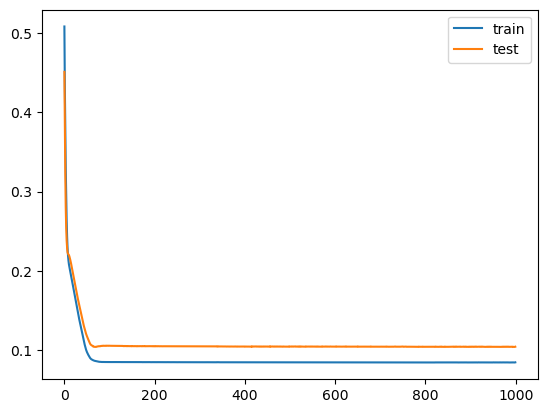

In [62]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [63]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

3/3 [==============================] - 0s 2ms/step
(94, 1)


In [64]:
train_predictions = model.predict(train_X)
print(train_predictions.shape)

13/13 [==============================] - 0s 2ms/step
(392, 1)


In [65]:
import pandas as pd
pd.DataFrame(train_y).to_csv('actualTrainLSTM .csv', index=False, header=False)
pd.DataFrame(train_predictions).to_csv('predictTrainLSTM .csv', index=False, header=False)
pd.DataFrame(test_y).to_csv('actualTestLSTM.csv', index=False, header=False)
pd.DataFrame(final_predictions).to_csv('predictTestLSTM.csv', index=False, header=False)

In [66]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_evaluation_metrics(y_observed, y_predicted):
     # Convert to NumPy arrays if they are lists
    if isinstance(y_observed, list):
        y_observed = np.array(y_observed)
    if isinstance(y_predicted, list):
        y_predicted = np.array(y_predicted)
        
    metrics = {}

    # Calculate ME (Mean Error)
    metrics['ME'] = np.mean(y_observed - y_predicted)

    # Calculate MAE (Mean Absolute Error)
    metrics['MAE'] = mean_absolute_error(y_observed, y_predicted)

    # Calculate MSE (Mean Squared Error)
    metrics['MSE'] = mean_squared_error(y_observed, y_predicted)

    # Calculate RMSE (Root Mean Squared Error)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Calculate NRMSE (Normalized Root Mean Squared Error)
    metrics['NRMSE'] = metrics['RMSE'] / (np.max(y_observed) - np.min(y_observed))

    # Calculate PBIAS (Percent Bias)
    metrics['PBIAS'] = np.mean(100 * (y_observed - y_predicted) / np.mean(y_observed))

    # Calculate RSR (Root Mean Square Ratio)
    metrics['RSR'] = metrics['RMSE'] / np.std(y_observed)

    # Calculate rSD (Ratio of the Standard Deviation)
    metrics['rSD'] = np.std(y_observed - y_predicted) / np.std(y_observed)

    # Calculate NSE (Nash-Sutcliffe Efficiency)
    metrics['NSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate mNSE (Modified Nash-Sutcliffe Efficiency)
    metrics['mNSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate rNSE (Relative Nash-Sutcliffe Efficiency)
    metrics['rNSE'] = metrics['NSE'] / np.var(y_observed)

    # Calculate d (Index of Agreement)
    metrics['d'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                       np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate md (Modified d Index)
    metrics['md'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate rd (Relative d Index)
    metrics['rd'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate cp (Coefficient of Performance)
    metrics['cp'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                         np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate r (Index of Agreement)
    metrics['r'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                        np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate R2 (Coefficient of Determination)
    metrics['R2'] = r2_score(y_observed, y_predicted)

    return metrics


In [67]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': -0.017064009, 'MAE': 0.10417332, 'MSE': 0.01766577, 'RMSE': 0.13291264, 'NRMSE': 0.14322737, 'PBIAS': -3.4516382, 'RSR': 0.45648298, 'rSD': 1.39398, 'NSE': -181.98179626464844, 'mNSE': -181.98179626464844, 'rNSE': -2146.567423374709, 'd': 0.4391481876373291, 'md': 0.4391481876373291, 'rd': 0.4391481876373291, 'cp': 0.4391481876373291, 'r': 0.4391481876373291, 'R2': 0.7916233078842406}


In [68]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adamax')

# Fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=102, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/1000
4/4 - 2s - loss: 0.4865 - val_loss: 0.4476 - 2s/epoch - 510ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.4390 - val_loss: 0.4016 - 36ms/epoch - 9ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.3979 - val_loss: 0.3603 - 34ms/epoch - 9ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.3617 - val_loss: 0.3229 - 36ms/epoch - 9ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.3298 - val_loss: 0.2888 - 33ms/epoch - 8ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.3021 - val_loss: 0.2606 - 32ms/epoch - 8ms/step
Epoch 7/1000
4/4 - 0s - loss: 0.2771 - val_loss: 0.2407 - 36ms/epoch - 9ms/step
Epoch 8/1000
4/4 - 0s - loss: 0.2551 - val_loss: 0.2253 - 35ms/epoch - 9ms/step
Epoch 9/1000
4/4 - 0s - loss: 0.2370 - val_loss: 0.2150 - 35ms/epoch - 9ms/step
Epoch 10/1000
4/4 - 0s - loss: 0.2216 - val_loss: 0.2078 - 31ms/epoch - 8ms/step
Epoch 11/1000
4/4 - 0s - loss: 0.2092 - val_loss: 0.2025 - 32ms/epoch - 8ms/step
Epoch 12/1000
4/4 - 0s - loss: 0.2000 - val_loss: 0.1999 - 34ms/epoch - 9ms/step
Epoch 13/1000
4/4 - 0s - loss: 0.1934

Epoch 103/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1047 - 33ms/epoch - 8ms/step
Epoch 104/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1047 - 35ms/epoch - 9ms/step
Epoch 105/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 34ms/epoch - 8ms/step
Epoch 106/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 35ms/epoch - 9ms/step
Epoch 107/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 37ms/epoch - 9ms/step
Epoch 108/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 35ms/epoch - 9ms/step
Epoch 109/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 35ms/epoch - 9ms/step
Epoch 110/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 34ms/epoch - 8ms/step
Epoch 111/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 112/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 34ms/epoch - 9ms/step
Epoch 113/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 114/1000
4/4 - 0s - loss: 0.0845 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 115/1000
4

Epoch 203/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 34ms/epoch - 8ms/step
Epoch 204/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 31ms/epoch - 8ms/step
Epoch 205/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 28ms/epoch - 7ms/step
Epoch 206/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 31ms/epoch - 8ms/step
Epoch 207/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 32ms/epoch - 8ms/step
Epoch 208/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 35ms/epoch - 9ms/step
Epoch 209/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 210/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 211/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 34ms/epoch - 8ms/step
Epoch 212/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 213/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 34ms/epoch - 8ms/step
Epoch 214/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1050 - 33ms/epoch - 8ms/step
Epoch 215/1000
4

Epoch 303/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 304/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 305/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1050 - 31ms/epoch - 8ms/step
Epoch 306/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 34ms/epoch - 8ms/step
Epoch 307/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 308/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1050 - 32ms/epoch - 8ms/step
Epoch 309/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 310/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 311/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 312/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1050 - 35ms/epoch - 9ms/step
Epoch 313/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 32ms/epoch - 8ms/step
Epoch 314/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1049 - 34ms/epoch - 8ms/step
Epoch 315/1000
4

Epoch 403/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 32ms/epoch - 8ms/step
Epoch 404/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1049 - 33ms/epoch - 8ms/step
Epoch 405/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 41ms/epoch - 10ms/step
Epoch 406/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 44ms/epoch - 11ms/step
Epoch 407/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 31ms/epoch - 8ms/step
Epoch 408/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 37ms/epoch - 9ms/step
Epoch 409/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 42ms/epoch - 11ms/step
Epoch 410/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 37ms/epoch - 9ms/step
Epoch 411/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 33ms/epoch - 8ms/step
Epoch 412/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1047 - 34ms/epoch - 9ms/step
Epoch 413/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1048 - 48ms/epoch - 12ms/step
Epoch 414/1000
4/4 - 0s - loss: 0.0844 - val_loss: 0.1048 - 36ms/epoch - 9ms/step
Epoch 415/10

Epoch 503/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 38ms/epoch - 9ms/step
Epoch 504/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1047 - 33ms/epoch - 8ms/step
Epoch 505/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 33ms/epoch - 8ms/step
Epoch 506/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1047 - 31ms/epoch - 8ms/step
Epoch 507/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 31ms/epoch - 8ms/step
Epoch 508/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 31ms/epoch - 8ms/step
Epoch 509/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 32ms/epoch - 8ms/step
Epoch 510/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 31ms/epoch - 8ms/step
Epoch 511/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 31ms/epoch - 8ms/step
Epoch 512/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 34ms/epoch - 8ms/step
Epoch 513/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 32ms/epoch - 8ms/step
Epoch 514/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1046 - 32ms/epoch - 8ms/step
Epoch 515/1000
4

Epoch 603/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 35ms/epoch - 9ms/step
Epoch 604/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1045 - 34ms/epoch - 9ms/step
Epoch 605/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1046 - 33ms/epoch - 8ms/step
Epoch 606/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1045 - 35ms/epoch - 9ms/step
Epoch 607/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1046 - 33ms/epoch - 8ms/step
Epoch 608/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1045 - 35ms/epoch - 9ms/step
Epoch 609/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 32ms/epoch - 8ms/step
Epoch 610/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 33ms/epoch - 8ms/step
Epoch 611/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 30ms/epoch - 7ms/step
Epoch 612/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 34ms/epoch - 8ms/step
Epoch 613/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1044 - 79ms/epoch - 20ms/step
Epoch 614/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1046 - 32ms/epoch - 8ms/step
Epoch 615/1000


Epoch 703/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 34ms/epoch - 9ms/step
Epoch 704/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 36ms/epoch - 9ms/step
Epoch 705/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 33ms/epoch - 8ms/step
Epoch 706/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 35ms/epoch - 9ms/step
Epoch 707/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1046 - 34ms/epoch - 8ms/step
Epoch 708/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1044 - 32ms/epoch - 8ms/step
Epoch 709/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 32ms/epoch - 8ms/step
Epoch 710/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 32ms/epoch - 8ms/step
Epoch 711/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 712/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 33ms/epoch - 8ms/step
Epoch 713/1000
4/4 - 0s - loss: 0.0843 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 714/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1045 - 33ms/epoch - 8ms/step
Epoch 715/1000
4

Epoch 803/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 31ms/epoch - 8ms/step
Epoch 804/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 31ms/epoch - 8ms/step
Epoch 805/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 34ms/epoch - 9ms/step
Epoch 806/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 807/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 35ms/epoch - 9ms/step
Epoch 808/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 31ms/epoch - 8ms/step
Epoch 809/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 34ms/epoch - 9ms/step
Epoch 810/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 811/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 35ms/epoch - 9ms/step
Epoch 812/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 813/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 35ms/epoch - 9ms/step
Epoch 814/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 32ms/epoch - 8ms/step
Epoch 815/1000
4

Epoch 903/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 32ms/epoch - 8ms/step
Epoch 904/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 905/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 906/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 35ms/epoch - 9ms/step
Epoch 907/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 32ms/epoch - 8ms/step
Epoch 908/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 33ms/epoch - 8ms/step
Epoch 909/1000
4/4 - 0s - loss: 0.0841 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 910/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 30ms/epoch - 8ms/step
Epoch 911/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1043 - 32ms/epoch - 8ms/step
Epoch 912/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 41ms/epoch - 10ms/step
Epoch 913/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1044 - 33ms/epoch - 8ms/step
Epoch 914/1000
4/4 - 0s - loss: 0.0842 - val_loss: 0.1042 - 33ms/epoch - 8ms/step
Epoch 915/1000


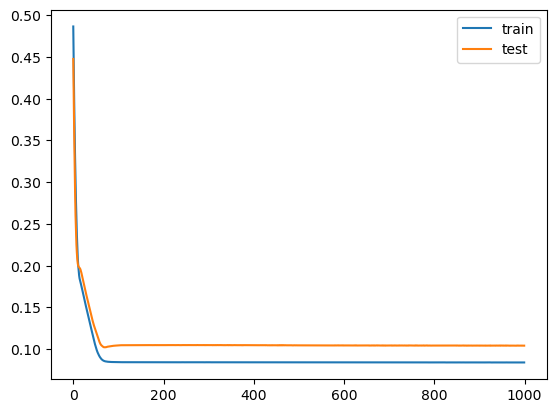

In [69]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

3/3 [==============================] - 0s 2ms/step
(94, 1)


In [71]:
train_predictions = model.predict(train_X)
print(train_predictions.shape)

13/13 [==============================] - 0s 2ms/step
(392, 1)


In [72]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': -0.011263077, 'MAE': 0.10427587, 'MSE': 0.017640645, 'RMSE': 0.13281809, 'NRMSE': 0.14312547, 'PBIAS': -2.2782466, 'RSR': 0.45615825, 'rSD': 1.3908083, 'NSE': -180.96934509277344, 'mNSE': -180.96934509277344, 'rNSE': -2134.625049203702, 'd': 0.4393762946128845, 'md': 0.4393762946128845, 'rd': 0.4393762946128845, 'cp': 0.4393762946128845, 'r': 0.4393762946128845, 'R2': 0.7919196712949194}


In [73]:
pd.DataFrame(train_y).to_csv('actualTrainGRU .csv', index=False, header=False)
pd.DataFrame(train_predictions).to_csv('predictTrainGRU.csv', index=False, header=False)
pd.DataFrame(test_y).to_csv('actualTestGRU.csv', index=False, header=False)
pd.DataFrame(final_predictions).to_csv('predictTestGRU.csv', index=False, header=False)